# Clasificación y agrupación de Radiogalaxias

Gracias a los nuevos surveys de radio galaxias tenemos miles de imágenes de radiogalaxias que nos podrían ayudar a entender las propiedades de estas. Sin embargo la cantidad de datos hace imposible el análisis manual y se requieren nuevas técnicas automatizadas como "Machine Learning". 

Un reto fundamental es que los métodos de aprendizaje máquina que se usarán deben ser invariantes a la rotación y translación de estas imágenes. Muchos métodos se basan en la distancia Euclidiana; sin embargo un problema con esta métrica es que al rotar una imagen, la distancia entre la imágen original y el resultado de la rotación ya no es cero.

In [51]:
from keras.datasets import mnist #usamos keras para descargar MNIST
import matplotlib.pyplot as plt #matplotlib para graficar
from numba import jit #easy paralleization
import numpy as np
import skimage.morphology as morpho
from astropy.io import fits
import skimage as sk
from astropy.io import fits
import skimage as sk
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%run imgutils

In [52]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
im1 = x_train[0] > 50 #umbral fijo para el ejemplo
imr = np.rot90(im1)

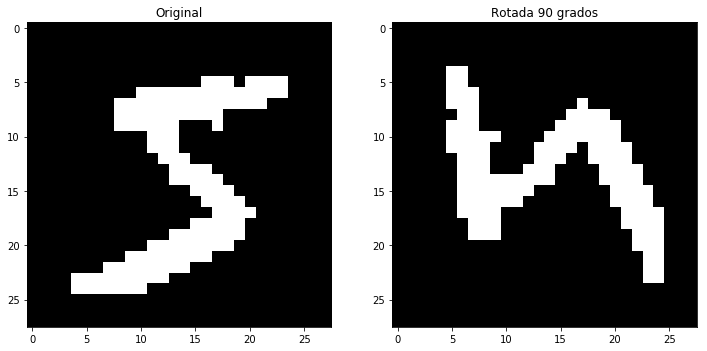

Norma de Original - Rotada : 15.684387141358123


In [53]:
f, ax = plt.subplots(1, 2, figsize=(12,15))
ax[0].set_title('Original') ; ax[0].imshow(im1, cmap='gray')
ax[1].set_title('Rotada 90 grados') ; ax[1].imshow(imr, cmap='gray')
plt.show()
print("Norma de Original - Rotada : {0}".format(np.linalg.norm(im1 ^ imr)))

En la literatura actual de agrupación de radio galaxias vemos que el uso de Self Organizing Maps (SOM) tiene cierta popularidad. SOM es un algoritmo cuyo objetivo es organizar o visualizar los datos asociandolos a puntos en el plano de tal forma que dos datos similares están asociados a puntos cercanos o inclusive al mismo punto, y datos muy diferentes están asociados a puntos muy lejanos en el plano.

<center>

![SOM_MNIST](somnist.png)
</center>


Esta similitud usualmente se mide con la distancia Euclidiana, pero como ya vimos esta tiene problemas cuando se aplica a imágenes ya que no es invariante a rotación o translación. Afortunadamente las imágenes de Surveys de Radio vienen centrados en las fuentes emisoras, por lo que nos ahorramos el problema de translación. Para el problema de rotación encontramos dos soluciones en la literatura, la propuesta por T.J. Galvin [1] y N.O. Ralph[2].

La solución de Galvin[1] es muy similar a una propuesta por [K.L. Polsterer](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.720.8082&rep=rep1&type=pdf)[3] en la cual para cada dato (fuente emisora) se generan rotaciones de la imágen original en incrementos de un grado, de tal forma que por cada dato tenemos 360 imágenes. Se toma la distancia entre dos datos como la distancia euclidiana mínima entre la imagen original de un dato y las 360 del otro. Lo bueno de esta solución es que fácil de entender, es bastante robusta y altamente paralelizable, lamentablemente cuandos se usa en conjuntos de datos muy grandes se requiere bastante poder de cómputo.

Por otra parte la solución propuesta por Ralph [2] la cual intenta minimizar la cantidad de cómputo utilizado. Se aplica un método de reducción de dimensión basado en un auto-encoder. El auto-encoder que se usa es una red neuronal convolucionada. Para abordar el problema de invarianza rotacional se introducen rotaciones aleatorias de los datos en cada iteración del optimizador de la red neuronal. Una vez entrenada la red, podemos tomar las representaciones de los datos en un espacio menor y aplicar SOM. En este algoritmo la robustez y la cantidad de poder de cómputo utilizado dependerán del número de iteraciones utilizadas para entrenar la red al igual que del tamaño de la reducción de dimensión que se realiza. Una gran ventaja de este método es se pueden aplicar culquier técnicas de aprendizaje de máquina sobre los datos cifrados y no sólo nos limitamos a SOM.

Como parte de este proyecto queremos buscar o proponer enfoques que trabajen de forma más directa sobre la morfología de las radio galaxias para poder incorporar invariancia bajo rotaciones en los métodos de aprendizaje.

## Propuesta


### Análisis Morfológico

En análisis morfológico tenemos dos operaciones elementales sobre las cuales podemos construir otras. Estas operaciones son la dilatación y la erosión. La erosión se obtiene al pasar el elemento estructurante sobre la imágen y se conservan sólo los píxeles centrales donde el elemento estructurante cabe por completo, es decir todo el elemento estructurante está sobre pixeles blancos.

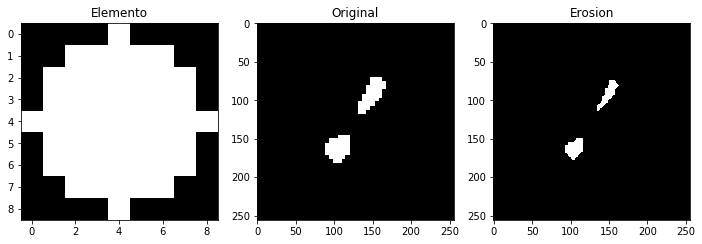

In [61]:
im = normalize_img(fits.open('nvss_3.fit')[0].data)
imT = im > sk.filters.threshold_otsu(im)
f, ax = plt.subplots(1, 3, figsize=(12,15))
d1 = morpho.disk(4)
ax[0].set_title('Elemento')
ax[0].imshow(d1, cmap='gray')
ax[1].set_title('Original')
ax[1].imshow(imT, cmap='gray')
ax[2].set_title('Erosion')
ax[2].imshow(morpho.erosion(imT, d1), cmap='gray')
plt.show()

Cuando se utiliza un operador morfológico circular, estas operaciones son prácticamente invariantes a rotación (dada la estructura cuadriculada de una imágen no se puede obtener invariancia rotacional por completo). Podemos combinar los operadores morfológicos básicos y crear nuevos operadores, como la apertura morfológica. La apertura morfológica consiste en aplicar una erosión y una dilatación en ese orden. Lo interesante de la apertura morfológica es que esta remueve elementos finos o picos de la imágen, por lo que al medir los cambios en áreas entre la imágen original y la imagen después de aplicar una apertura morfológica con diferentes tamaños de elementos estructurantes obtendremos información sobre la cantidad de partes finas en la imágen. 

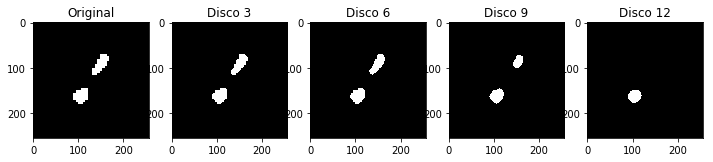

In [63]:
import skimage.morphology as morpho
f, ax = plt.subplots(1, 5, figsize=(12,15))
ax[0].imshow(imT, cmap='gray') #umbral fijo para el ejemplo
ax[0].set_title('Original')
for i in range(1, 5):
    d1 = morpho.disk(i * 3)
    imo = morpho.opening(imT, d1)
    ax[i].imshow(imo, cmap='gray')
    st = 'Disco ' + str(i * 3)
    ax[i].set_title(st)
plt.show()

Podemos aplicar aperturas sobre imágenes en escala de grises. Si vemos una imágen como un objeto tridimensional, donde la intensidad de cada pixel es el tercer eje, podemos aplicar los operadores morfológicos en tres dimensiones.

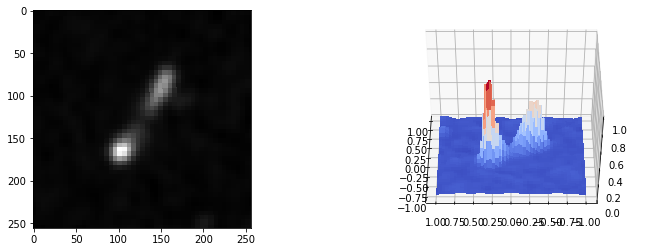

In [64]:
X = np.arange(-1, 1, 2/im.shape[0])
Y = np.arange(-1, 1, 2/im.shape[1])
X, Y = np.meshgrid(X, Y)
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.view_init(45, 180)
surf = ax.plot_surface(X, Y, im, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax = fig.add_subplot(1, 2, 1)
p = ax.imshow(im, cmap='gray')

In [65]:
%run radiomorpho.py
dirs = ('101first_fit', '101nvss_fit')
files, images = readImagesFromDirs(dirs) #cargamos todas las imagenes

error reading image 101first_fit/J0331-2849_z1.0890p_1.09Mpc.fi.fit or 101nvss_fit/J0331-2849_z1.0890p_1.09Mpc.nv.fit


In [88]:
dt = []
for im in images:
    dt.append( get_open_close_info(im[1], 8) )
dt = np.array(dt[:])
dt = dt[:,:8]

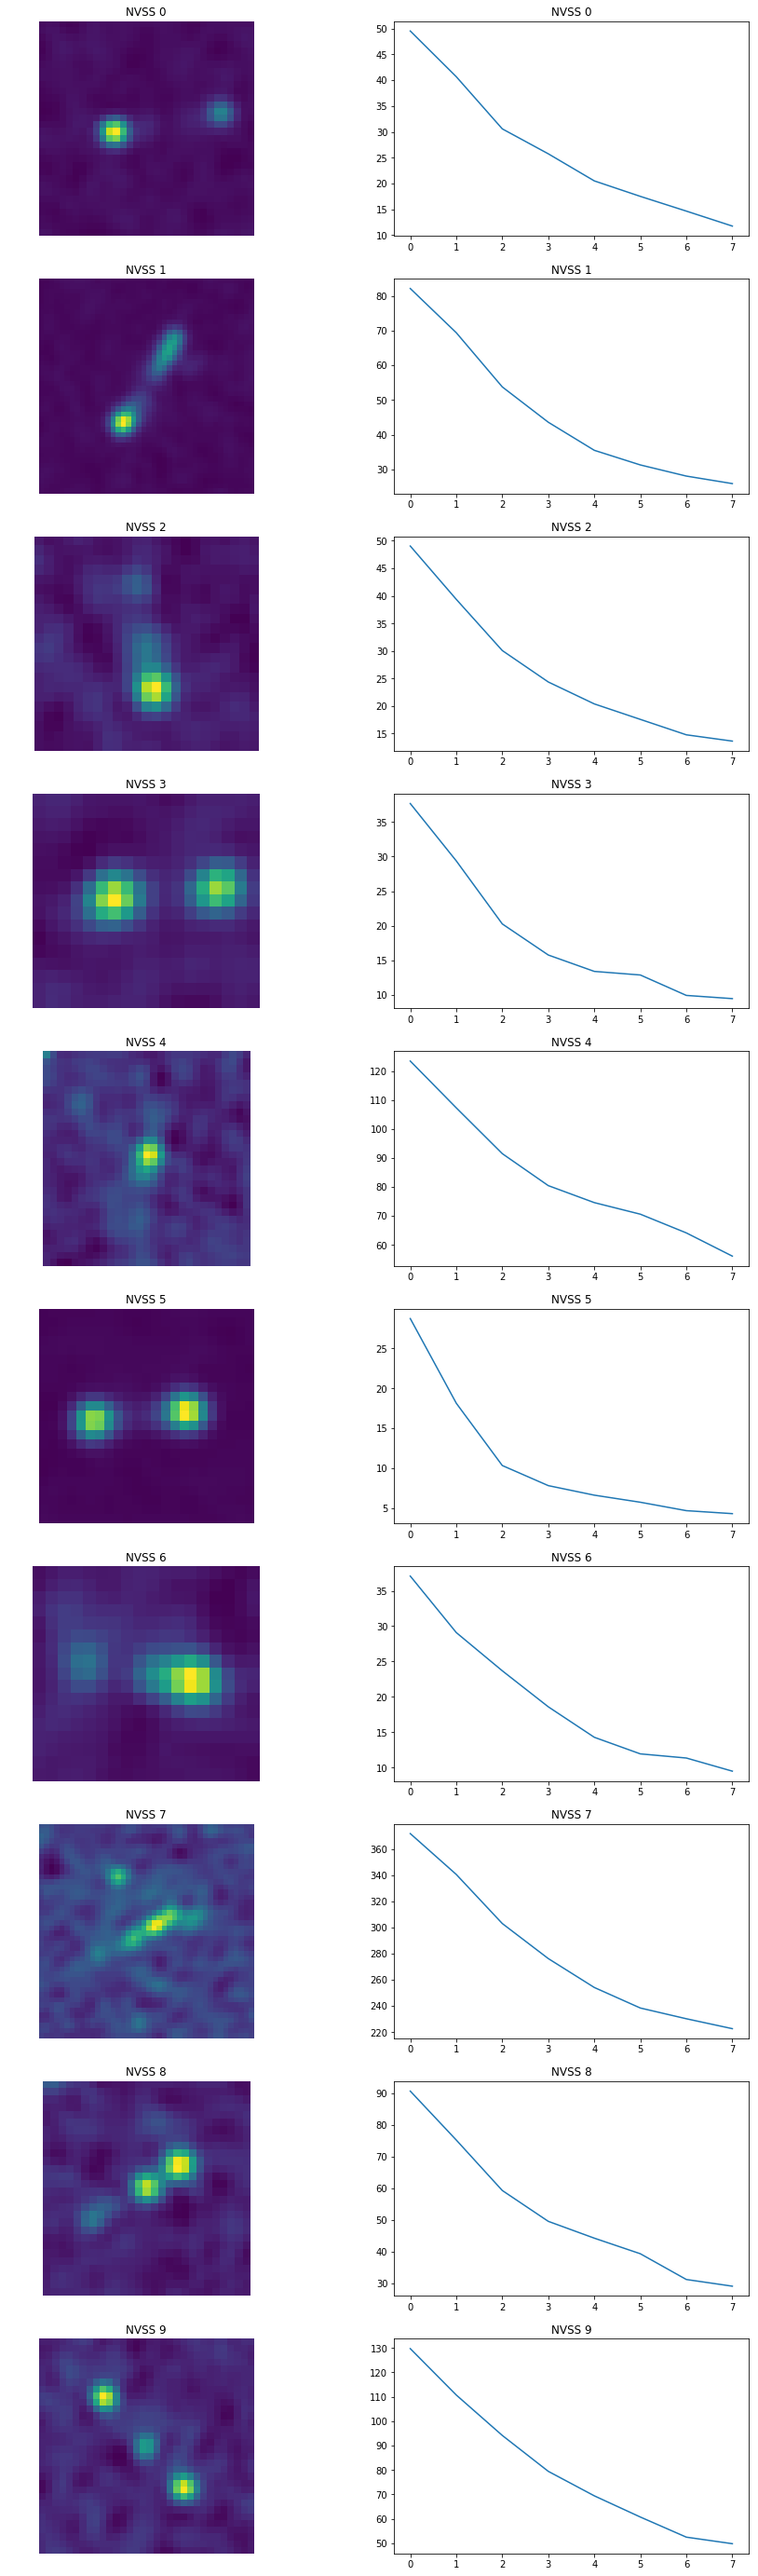

In [89]:
nimg = 10
f, ax = plt.subplots(nimg, 2, figsize=(15, nimg * 5))
for i in range(nimg):
    ax[i][0].axis('off')
#     ax[i][1].axis('off')
    ax[i][0].set_title('NVSS {}'.format(i))
    ax[i][1].set_title('NVSS {}'.format(i))
    ax[i][0].imshow(images[:,1][i])
    ax[i][1].plot(dt[i])
plt.show()

Tomamos algunos casos en especifico con imágenes similares, como NVSS(3) y NVSS(5) y NVSS(8) y NVSS(9), también agregamos una imágen muy diferente NVSS(7).

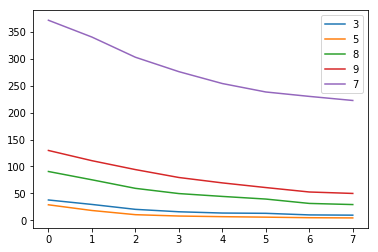

In [93]:
for i in [3,5,8,9,7]:
    plt.plot(dt[i], label=i)
plt.legend()
plt.show()